<a href="https://colab.research.google.com/github/GaetanAm/Sentiment-Analysis-and-Impact-on-Financial-Markets/blob/main/notebooks/Stage_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stage 3:** Machine Learning Project Notebook

In [38]:
# Disable unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

# Necessary imports

# Standard libraries
import os
import json
from datetime import date
from io import StringIO
from zipfile import ZipFile

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px

# Progress bar
from tqdm.notebook import tqdm

# Financial data
import yfinance as yf

# Machine learning and preprocessing
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    learning_curve,
    cross_validate,
    KFold
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    plot_tree
)
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    BaggingRegressor,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    GradientBoostingRegressor
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    make_scorer,
    roc_auc_score
)

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Text analysis
from textblob import TextBlob
from huggingface_hub import login
from transformers import pipeline

# TensorFlow and Keras for deep learning
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner.tuners import RandomSearch


# XML Parsing
from lxml import etree

# Google Colab specific imports
from google.colab import files, userdata


## Stock Price Data Extraction and Initial Exploration


In [19]:
tickers = ['TSLA', 'AAPL', 'AMZN', 'JPM', 'NFLX', 'NVDA', 'GOOG', 'NKE', 'DIS', 'BABA', 'SHOP']
start = '2010-01-01'
end = '2018-12-31'
df_ticker_return = pd.DataFrame()
for ticker in tickers:
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start = start, end = end)
        df_ticker_return['ticker']= ticker
    else:
        data_temp = ticker_yf.history(start = start, end = end)
        data_temp['ticker']= ticker
        df_ticker_return = pd.concat([df_ticker_return, data_temp])
df_ticker_return.to_csv(r'return_data.csv')

In [20]:
df_ticker_return.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,TSLA
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,TSLA
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,TSLA
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,TSLA
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,TSLA


In [21]:
# We can preread the data
df_ticker_return = pd.read_csv('return_data.csv',
                               index_col='Date')
df_ticker_return.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0,TSLA
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0,TSLA
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0,TSLA
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0,TSLA
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0,TSLA


In [22]:
tickers = list(df_ticker_return['ticker'].unique())
print(tickers)

['TSLA', 'AAPL', 'AMZN', 'JPM', 'NFLX', 'NVDA', 'GOOG', 'NKE', 'DIS', 'BABA', 'SHOP']


In [23]:
# Load the data
df = pd.read_csv('return_data.csv', index_col='Date', parse_dates=True)

# Check for missing values
print("Missing values by column:\n", df.isnull().sum())

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])  # Ignore the 'ticker' column

Missing values by column:
 Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
ticker          0
dtype: int64


In [24]:
# Standardization with StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

# Normalization with MinMaxScaler
minmax_scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized.iloc[:, :-1] = minmax_scaler.fit_transform(df.iloc[:, :-1])

In [25]:
# Add a dummy 'target' column for demonstration purposes
df['target'] = (df['Close'] > df['Close'].median()).astype(int)

# Use SMOTE to balance the classes
smote = SMOTE()
X = df.drop(columns=['target', 'ticker'])
y = df['target']
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new proportions
print("Proportions after SMOTE:\n", y_resampled.value_counts())

Proportions after SMOTE:
 target
0    11116
1    11116
Name: count, dtype: int64


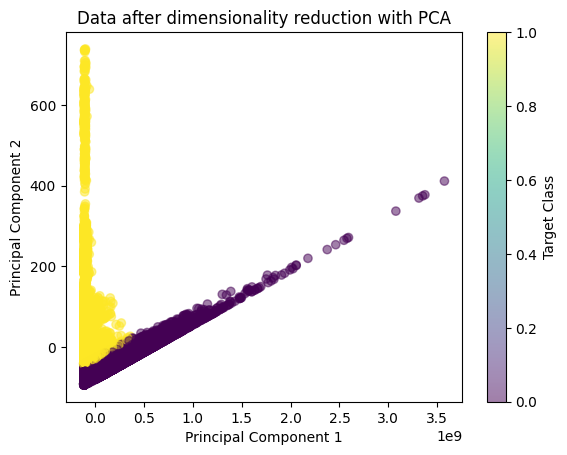

In [26]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Visualize the reduced data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='viridis', alpha=0.5)
plt.title("Data after dimensionality reduction with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Target Class')
plt.show()

The visualization shows distinct clusters for the two classes, suggesting that the resampling technique (SMOTE) effectively balanced the classes.
The separability of the classes indicates that PCA retained meaningful variance, which can aid machine learning algorithms in distinguishing between the classes.

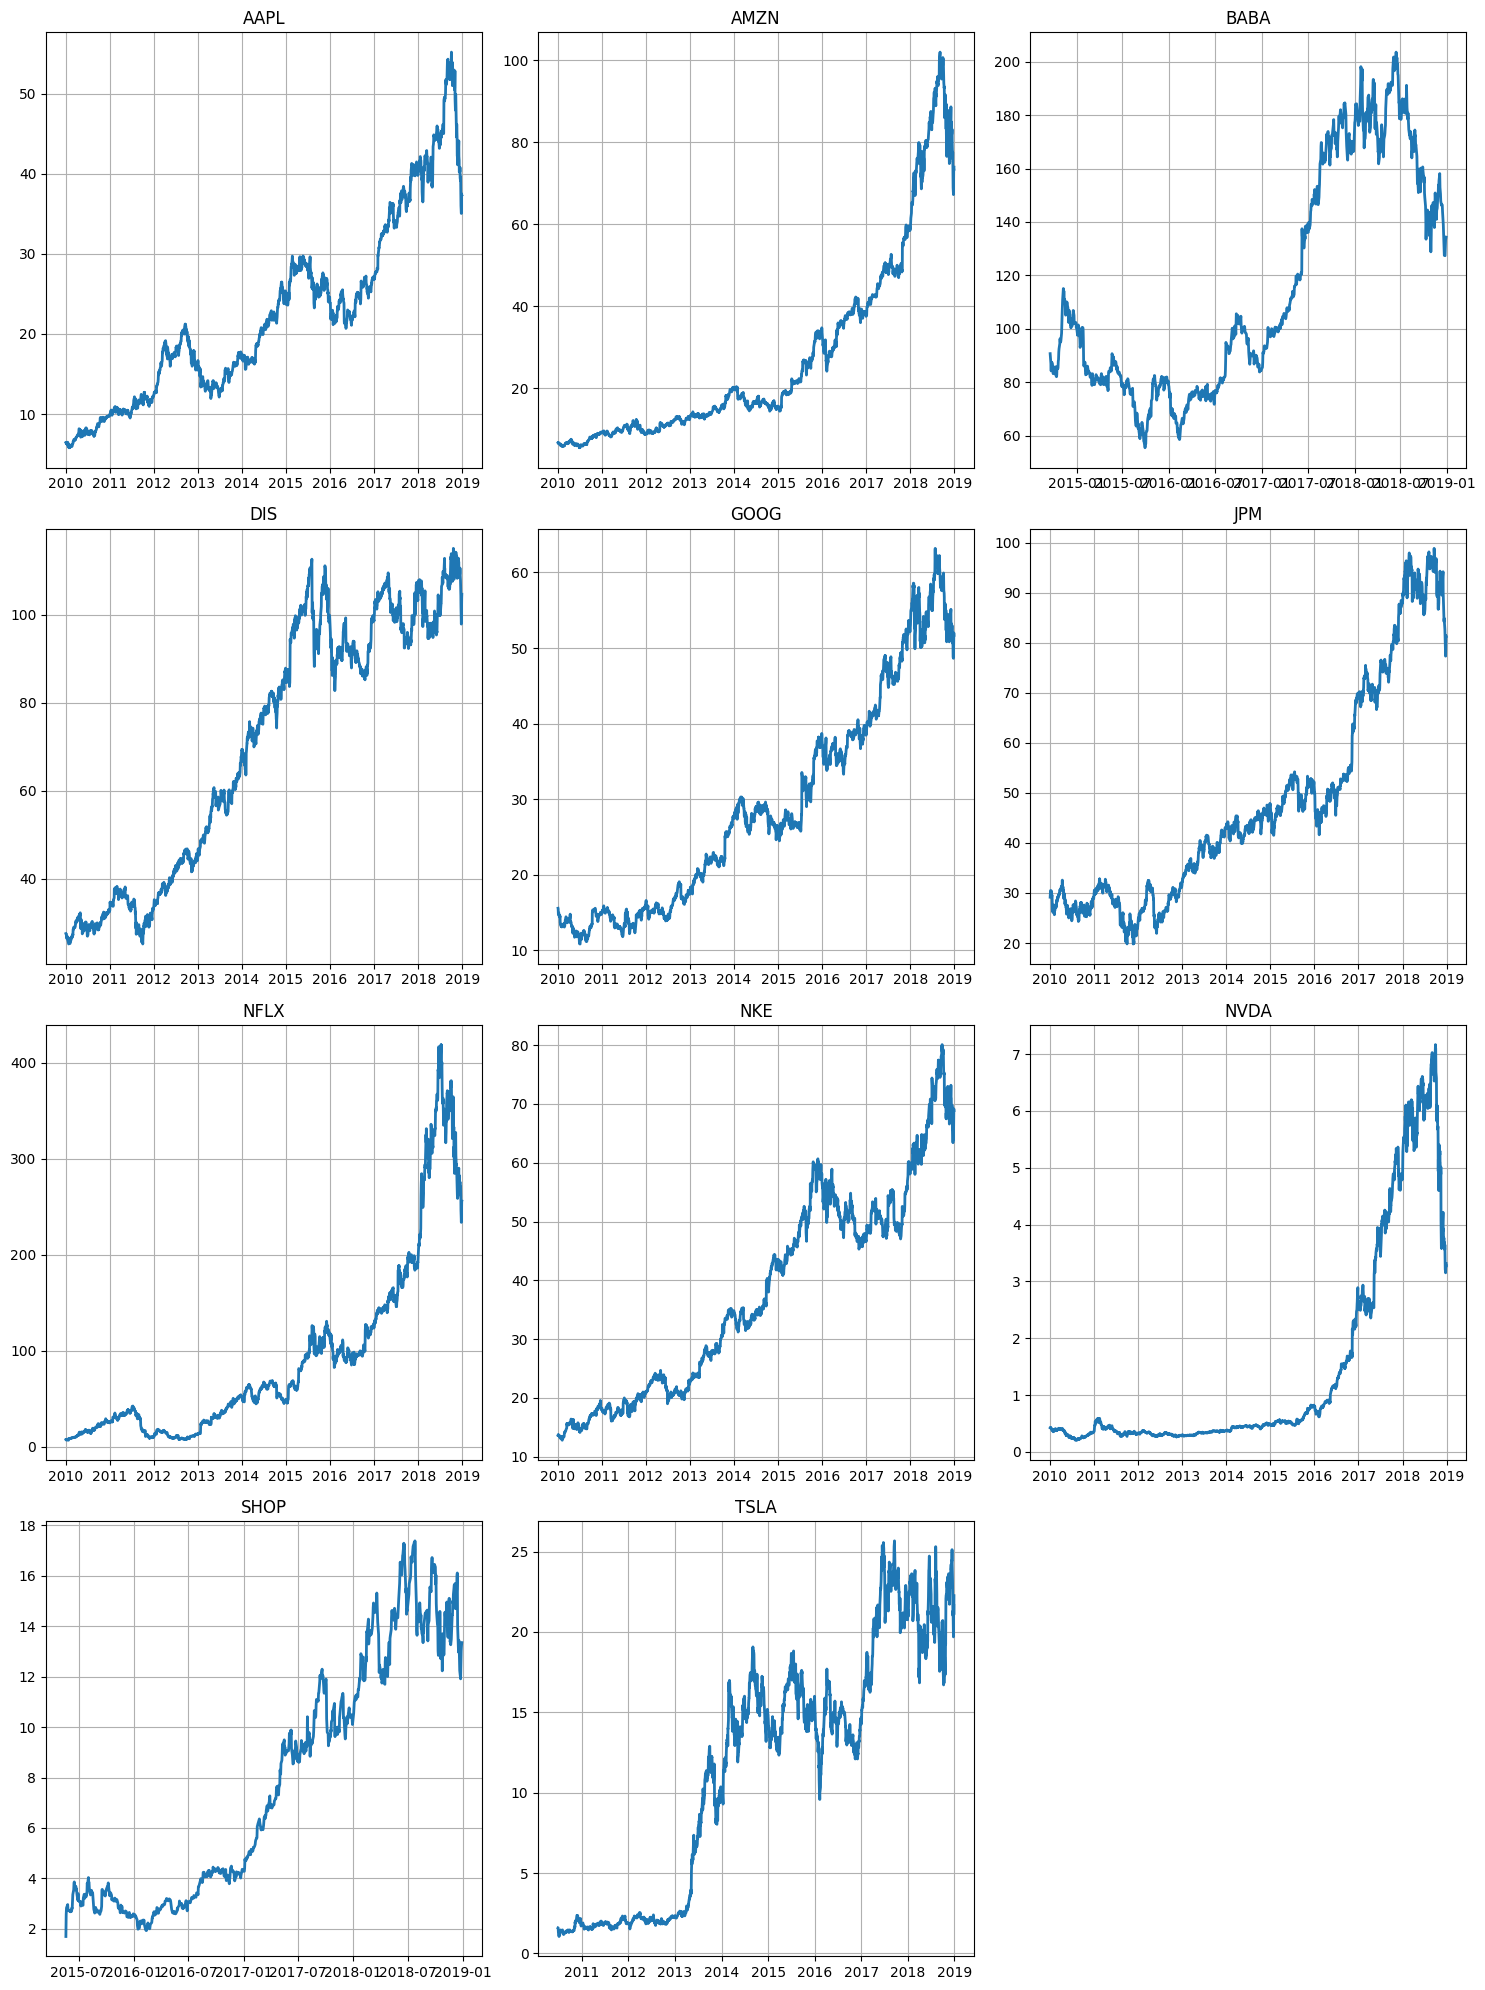

In [27]:
# Calculate the number of unique tickers
tickers = list(df['ticker'].unique())
num_tickers = len(tickers)

# Determine grid dimensions
cols = 3  # Set the number of columns
rows = math.ceil(num_tickers / cols)  # Dynamically calculate the number of rows

# Create the grid with the appropriate number of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plot the time series for each ticker
for idx, (ticker, group) in enumerate(df.groupby('ticker')):
    axes[idx].plot(group['Close'], linewidth=2, label=ticker)
    axes[idx].set_title(ticker)
    axes[idx].grid(True)

# Turn off unused axes (if the grid exceeds the number of tickers)
for ax in axes[num_tickers:]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

The plots provide an overview of stock trends that show:

The dominance of tech-driven growth during the 2010s.

The varying impact of market cycles and external factors on individual companies.

Potential opportunities for further analysis of periods of volatility, sharp corrections, or growth plateaus to understand their drivers.

This analysis serves as a foundation for correlating these stock price movements with sentiment data in subsequent modeling efforts.

In [28]:
from google.colab import files
uploaded = files.upload()

Saving Raw Headline Data.zip to Raw Headline Data.zip


In [29]:
import zipfile
import json
import os

# Get the current working directory
current_directory = os.getcwd()

# Construct the path to the zip file relative to the current directory
zip_file_path = os.path.join(current_directory, "Raw Headline Data.zip")

# Print the path to verify it's correct
print(f"Looking for the file at: {zip_file_path}")

# Try opening the zip file
try:
    z = zipfile.ZipFile(zip_file_path, "r")
    testFile = z.namelist()[10]
    fileData = z.open(testFile).read()
    fileDataSample = json.loads(fileData)['content'][1:500]

    # json format
    print(fileDataSample)

except FileNotFoundError:
    print(f"Error: File not found at {zip_file_path}. Please ensure the file is present and the path is correct.")

Looking for the file at: /content/Raw Headline Data.zip
li class="n-box-item date-title" data-end="1305172799" data-start="1305086400" data-txt="Tuesday, December 17, 2019">Wednesday, May 11, 2011</li><li class="n-box-item sa-box-item" data-id="76179" data-ts="1305149244"><div class="media media-overflow-fix"><div class="media-left"><a class="box-ticker" href="/symbol/CSCO" target="_blank">CSCO</a></div><div class="media-body"><h4 class="media-heading"><a href="/news/76179" sasource="on_the_move_news_fidelity" target="_blank">Cisco (NASDAQ:CSCO): Pr


In [30]:
# helper function performs the jsn parsing

def jsonParser(json_data):
    xml_data = json_data['content']

    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    assert len(main_tickers) == json_data['count']
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]

    return main_tickers, final_headlines


data = None
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("/content/Raw Headline Data.zip", "r") as z:

    for filename in tqdm(z.namelist()):
#         print(filename)
        try:
            #print('Running {}'.format(filename))
            with z.open(filename) as f:
                data = f.read()
                json_data = json.loads(data)
            if json_data.get('count', 0)> 10:

                #Step 1: Parse the News Jsons
                main_tickers, final_headlines = jsonParser(json_data)

                if len(final_headlines) != json_data['count']:
                    continue

                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker.
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))

               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,
                           'date': [file_date] * len(main_tickers)}

                df_f = pd.DataFrame(df_dict)
                data_df_news.append(df_f)

        except:
            pass

data_df_news=pd.concat(data_df_news)
display(data_df_news.head())
print(data_df_news.shape)

  0%|          | 0/3159 [00:00<?, ?it/s]

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02


(122613, 3)


In [31]:
# select all tickers except for empty
data_df_news = data_df_news[~(data_df_news['ticker'] == '')]
data_df_news.shape

(110711, 3)

## Distribution of Headlines per Ticker in the Dataset



In [32]:
px.bar(data_df_news['ticker'].value_counts()[:100],template="plotly_white")

The bar chart shows the distribution of news headlines across various stock tickers in the dataset. It is evident that certain tickers, such as TSLA and AAPL, have significantly higher coverage compared to others. This disparity suggests that these stocks may dominate sentiment analysis due to their higher data availability. Conversely, tickers with fewer headlines might result in less reliable sentiment predictions.


##  Data Integration

In [33]:
#Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()

#Computing the event return
rtp1 = df_ticker_return['ret_curr'].shift(1) # return a day after the news
rt = df_ticker_return['ret_curr'] # return the day of the news

df_ticker_return['eventRet'] =  rt + rtp1
df_ticker_return.reset_index(level=0, inplace=True)

df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

In [34]:
# merge on date and ticker
df_all = pd.merge(data_df_news, df_ticker_return,
                  how='left',
                  left_on=['date','ticker'],
                  right_on=['date','ticker'])

df_all = df_all[df_all['ticker'].isin(tickers)]
df_all = df_all[['ticker','headline','date','eventRet','Close']]
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)
df_all.to_csv('combined.csv',index=False)

In [35]:
# preread combined dataframe
data_df = pd.read_csv('combined.csv')
data_df = data_df.dropna()
data_df.head()

,ticker,headline,date,eventRet,Close
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.031269,10.059500
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,0.012173,33.884285
2,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,0.010426,10.303500
3,NVDA,Nvidia (NVDA -8.2%) shares slump after Needham...,2011-05-13,-0.077562,0.418649
4,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.031297,12.865873


In [36]:
print(data_df.shape, data_df.ticker.unique().shape)

(2586, 5) (11,)


In [39]:
data_df['sent_blob'] = data_df['headline'].apply(lambda row: TextBlob(row).sentiment.polarity)
data_df.head()

,ticker,headline,date,eventRet,Close,sent_blob
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.031269,10.059500,0.262500
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,0.012173,33.884285,-0.043750
2,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,0.010426,10.303500,0.000000
3,NVDA,Nvidia (NVDA -8.2%) shares slump after Needham...,2011-05-13,-0.077562,0.418649,0.113636
4,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.031297,12.865873,0.125000


The data preprocessing and integration phase successfully aligned financial news headlines with corresponding stock returns, creating a comprehensive dataset for further sentiment analysis. By leveraging TextBlob, sentiment polarity was extracted from the headlines, enabling an initial exploration of the relationship between sentiment and stock price changes.

The merged dataset includes key features such as ticker symbols, headlines, event returns, closing prices, and sentiment scores. This structured dataset provides a solid foundation for implementing advanced machine learning models to predict market movements based on sentiment.

In [40]:
login(userdata.get('LOGIN_HF'))
# Charger FinBERT
sentiment_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")
def analyze_sentiment(text):
    try:
        return sentiment_pipeline(inputs=text)[0]['label']  # Utiliser "inputs" si "text" ne fonctionne pas
    except Exception as e:
        print(f"Erreur avec le texte : {text} -> {e}")
        return "Error"
# Appliquer l'analyse des sentiments à tous les titres
data_df['sent_finbert'] = data_df['headline'].apply(analyze_sentiment)

# Afficher un aperçu des résultats
print(data_df[['headline', 'sent_finbert']].head())

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Device set to use cpu


                                            headline sent_finbert
0  Whole Foods (WFMI) -5.2% following a downgrade...      Neutral
1  Netflix (NFLX +1.1%) shares post early gains a...     Positive
2  Amazon.com (AMZN -1.7%) shares slip as comment...     Negative
3  Nvidia (NVDA -8.2%) shares slump after Needham...     Negative
4  It's been some time coming, but Google (GOOG -...      Neutral


In [41]:
data_df.head()

,ticker,headline,date,eventRet,Close,sent_blob,sent_finbert
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.031269,10.059500,0.262500,Neutral
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,0.012173,33.884285,-0.043750,Positive
2,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,0.010426,10.303500,0.000000,Negative
3,NVDA,Nvidia (NVDA -8.2%) shares slump after Needham...,2011-05-13,-0.077562,0.418649,0.113636,Negative
4,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.031297,12.865873,0.125000,Neutral


In [42]:
def map_finbert_sentiment(label):
    if label == "Positive":
        return 1
    elif label == "Negative":
        return -1
    else:
        return 0

data_df['sent_finbert_score'] = data_df['sent_finbert'].apply(map_finbert_sentiment)

In [43]:
data_df.head()

,ticker,headline,date,eventRet,Close,sent_blob,sent_finbert,sent_finbert_score
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.031269,10.059500,0.262500,Neutral,0
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,0.012173,33.884285,-0.043750,Positive,1
2,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,0.010426,10.303500,0.000000,Negative,-1
3,NVDA,Nvidia (NVDA -8.2%) shares slump after Needham...,2011-05-13,-0.077562,0.418649,0.113636,Negative,-1
4,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.031297,12.865873,0.125000,Neutral,0


In [44]:
# Suppression de la colonne 'sent_finbert'
data_df = data_df.drop(columns=['sent_finbert'])

# Sauvegarder le DataFrame en CSV
csv_path = "sentiment_data.csv"
data_df.to_csv(csv_path, index=False)

# Télécharger le fichier CSV

# files.download(csv_path)

## MACHINE LEARNING

### Initialisation

In [ ]:
url = "https://raw.githubusercontent.com/GaetanAm/Sentiment-Analysis-and-Impact-on-Financial-Markets/refs/heads/main/data/sentiment_data.csv"

data_df = pd.read_csv(url)

# Aperçu des données
print(data_df.head())


  ticker                                           headline        date  \
0   AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1   NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2   AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
3   NVDA  Nvidia (NVDA -8.2%) shares slump after Needham...  2011-05-13   
4   GOOG  It's been some time coming, but Google (GOOG -...  2011-05-16   

   eventRet      Close  sent_blob  sent_finbert_score  
0  0.031269  10.059500   0.262500                   0  
1  0.012173  33.884285  -0.043750                   1  
2  0.010426  10.303500   0.000000                  -1  
3 -0.077562   0.418649   0.113636                  -1  
4 -0.031297  12.865873   0.125000                   0  


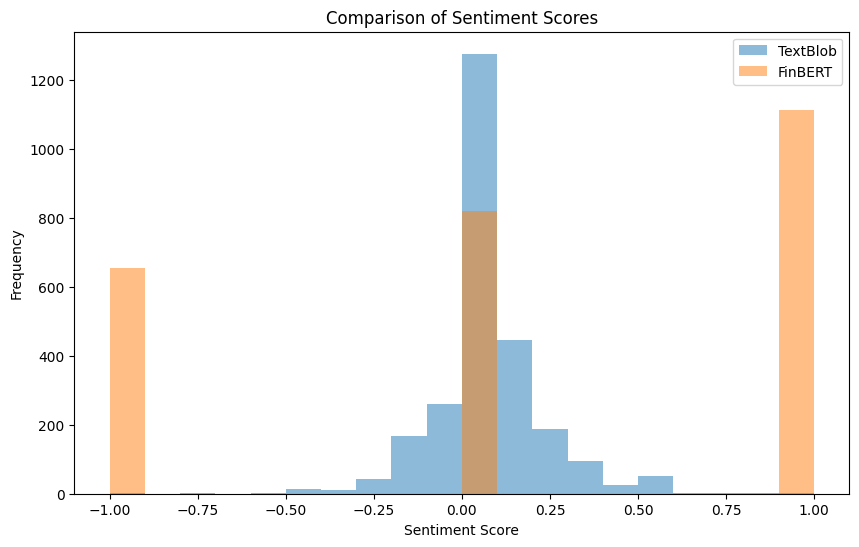

In [ ]:
# Compare the distributions
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(data_df['sent_blob'], bins=20, alpha=0.5, label='TextBlob')  # Plot TextBlob sentiment scores
plt.hist(data_df['sent_finbert_score'], bins=20, alpha=0.5, label='FinBERT')  # Plot FinBERT sentiment scores
plt.legend()
plt.title("Comparison of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


TextBlob:

The scores are concentrated around 0, suggesting that TextBlob often assigns neutral sentiments. This behavior is expected, as TextBlob is not specifically trained for financial contexts.

FinBERT:

The scores are more polarized, with a significant number of values near -1 and 1. This indicates that FinBERT is better at detecting strong positive or negative sentiments, likely due to its training on financial datasets.

Conclusion

This visualization highlights the suitability of FinBERT for financial sentiment analysis, as it provides more decisive sentiment classifications compared to the generalized behavior of TextBlob.

In [ ]:
#  we calculate the correlation between three variables
print(data_df[['eventRet', 'sent_blob', 'sent_finbert_score']].corr())

                    eventRet  sent_blob  sent_finbert_score
eventRet            1.000000   0.075331            0.294376
sent_blob           0.075331   1.000000            0.203759
sent_finbert_score  0.294376   0.203759            1.000000


Results

eventRet and sent_blob:

Correlation: 0.075 (low positive correlation).
TextBlob has a weak relationship with event returns, indicating limited predictive power for financial sentiment analysis.

eventRet and sent_finbert_score:

Correlation: 0.294 (moderate positive correlation).
FinBERT shows a stronger relationship with event returns, making it a better tool for analyzing financial sentiment.

sent_blob and sent_finbert_score:

Correlation: 0.204 (low positive correlation).
The two sentiment analysis tools have different methodologies and training data, which explains the low correlation between their scores.

Conclusion

FinBERT is more aligned with financial outcomes (eventRet) than TextBlob, confirming its suitability for financial sentiment analysis.
The correlation values indicate that while sentiment scores are useful, additional features or more complex models may be needed to better predict financial returns.

### Linear regression

In [ ]:
# TextBlob only
X_blob = data_df[['sent_blob']]
y = data_df['eventRet']  # Target variable for regression

# FinBERT only
X_finbert = data_df[['sent_finbert_score']]

# Combined data (TextBlob + FinBERT)
X_combined = data_df[['sent_blob', 'sent_finbert_score']]

TextBlob: Very low R² (0.003), indicating almost no explanatory power.

FinBERT: Slightly better R² (0.041), but still low.

Combined: Combining TextBlob and FinBERT scores marginally improves R² (0.0419).

These results suggest that neither TextBlob nor FinBERT alone is sufficient to explain event returns, and their combined effect is minimal.

--- TextBlob ---
Mean MSE: 0.0035 ± 0.0016
Mean R²: -0.0096 ± 0.0191

--- FinBERT ---
Mean MSE: 0.0032 ± 0.0015
Mean R²: 0.0806 ± 0.0327

--- Combined (TextBlob + FinBERT) ---
Mean MSE: 0.0032 ± 0.0015
Mean R²: 0.0807 ± 0.0328



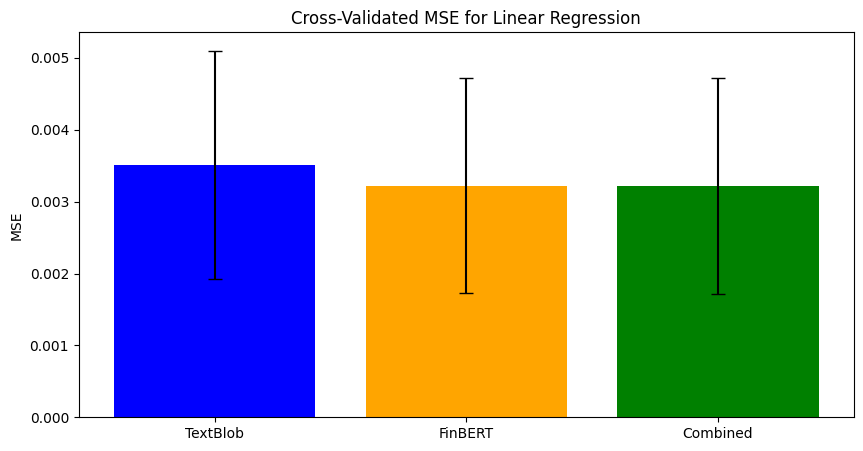

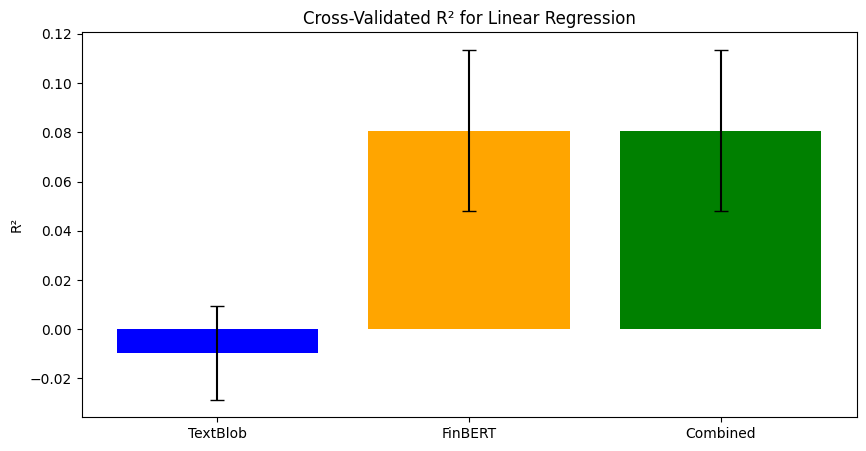

In [ ]:
# Function for k-fold cross-validation with linear regression
def cross_validate_linear_regression(X, y, label, cv=5):
    lin_reg = LinearRegression()

    # Calculate cross-validated MSE (negative because sklearn minimizes)
    mse_scores = -cross_val_score(lin_reg, X, y, scoring='neg_mean_squared_error', cv=cv)
    # Calculate cross-validated R²
    r2_scores = cross_val_score(lin_reg, X, y, scoring='r2', cv=cv)

    print(f"--- {label} ---")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}\n")

    return mse_scores, r2_scores

# Perform cross-validation for TextBlob
mse_blob_cv, r2_blob_cv = cross_validate_linear_regression(X_blob, y, "TextBlob")

# Perform cross-validation for FinBERT
mse_finbert_cv, r2_finbert_cv = cross_validate_linear_regression(X_finbert, y, "FinBERT")

# Perform cross-validation for Combined data
mse_combined_cv, r2_combined_cv = cross_validate_linear_regression(X_combined, y, "Combined (TextBlob + FinBERT)")

# Compile results for visualization
labels = ['TextBlob', 'FinBERT', 'Combined']
mse_means = [np.mean(mse_blob_cv), np.mean(mse_finbert_cv), np.mean(mse_combined_cv)]
mse_stds = [np.std(mse_blob_cv), np.std(mse_finbert_cv), np.std(mse_combined_cv)]
r2_means = [np.mean(r2_blob_cv), np.mean(r2_finbert_cv), np.mean(r2_combined_cv)]
r2_stds = [np.std(r2_blob_cv), np.std(r2_finbert_cv), np.std(r2_combined_cv)]

# Visualize MSE
plt.figure(figsize=(10, 5))
plt.bar(labels, mse_means, yerr=mse_stds, color=['blue', 'orange', 'green'], capsize=5)
plt.title("Cross-Validated MSE for Linear Regression")
plt.ylabel("MSE")
plt.show()

# Visualize R²
plt.figure(figsize=(10, 5))
plt.bar(labels, r2_means, yerr=r2_stds, color=['blue', 'orange', 'green'], capsize=5)
plt.title("Cross-Validated R² for Linear Regression")
plt.ylabel("R²")
plt.show()

MSE Comparison:

All models exhibit low MSE, but the differences between them are minimal.

R² Comparison:

TextBlob shows an almost negligible R², indicating it contributes little to explaining the target variable.

FinBERT has a higher R², but it is still limited.

Combining TextBlob and FinBERT scores slightly improves R², but the gain is marginal.

These visualizations confirm that sentiment scores alone (even when combined) have limited predictive power for event returns in this linear regression setting.

### Logistic regression

FinBERT alone provides better predictive performance for positive returns compared to TextBlob.

Combining both features does not yield additional benefits, suggesting that FinBERT captures most of the relevant information.



This analysis confirms that FinBERT is a better choice for financial sentiment classification tasks, while TextBlob adds little value in this context.

In [ ]:
# Ensure the target variable is binary
data_df['target_binary'] = (data_df['eventRet'] > 0).astype(int)
y = data_df['target_binary']
# Function for k-fold cross-validation with logistic regression
def cross_validate_logistic_regression(X, y, label, cv=5):
    log_reg = LogisticRegression(max_iter=1000)

    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
    }

    # Perform cross-validation
    scores = cross_validate(log_reg, X, y, scoring=scoring, cv=cv, return_train_score=False)

    print(f"--- {label} ---")
    for metric, values in scores.items():
        if 'test' in metric:
            print(f"{metric.replace('test_', '').capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")
    print("\n")

    return scores

# Apply cross-validation
print("Logistic Regression:")
scores_blob = cross_validate_logistic_regression(X_blob, y, "Logistic Regression - TextBlob")
scores_finbert = cross_validate_logistic_regression(X_finbert, y, "Logistic Regression - FinBERT")
scores_combined = cross_validate_logistic_regression(X_combined, y, "Logistic Regression - Combined")

Logistic Regression:
--- Logistic Regression - TextBlob ---
Accuracy: 0.5534 ± 0.0095
Precision: 0.5499 ± 0.0058
Recall: 0.9469 ± 0.0237
F1: 0.6956 ± 0.0070
Roc_auc: 0.5419 ± 0.0274


--- Logistic Regression - FinBERT ---
Accuracy: 0.6400 ± 0.0183
Precision: 0.6207 ± 0.0181
Recall: 0.8594 ± 0.0355
F1: 0.7201 ± 0.0111
Roc_auc: 0.6546 ± 0.0189


--- Logistic Regression - Combined ---
Accuracy: 0.6319 ± 0.0199
Precision: 0.6190 ± 0.0198
Recall: 0.8307 ± 0.0347
F1: 0.7087 ± 0.0117
Roc_auc: 0.6523 ± 0.0254




In [ ]:
# Extract mean scores for visualization
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = {
    'TextBlob': [np.mean(scores_blob[f'test_{metric}']) for metric in metrics],
    'FinBERT': [np.mean(scores_finbert[f'test_{metric}']) for metric in metrics],
    'Combined': [np.mean(scores_combined[f'test_{metric}']) for metric in metrics],
}

# Convert to DataFrame for easy visualization
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])
print(results_df)

           TextBlob   FinBERT  Combined
Accuracy   0.553362  0.639980  0.631857
Precision  0.549865  0.620744  0.619037
Recall     0.946941  0.859426  0.830716
F1-score   0.695594  0.720121  0.708660
ROC-AUC    0.541860  0.654553  0.652275


In [ ]:
# Function for logistic regression with class weighting
def cross_validate_logistic_regression_weighted(X, y, label, cv=5):
    log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc',  # Ensure ROC-AUC is included
    }

    # Perform cross-validation
    scores = cross_validate(log_reg, X, y, scoring=scoring, cv=cv, return_train_score=False)

    print(f"--- {label} (with Class Weighting) ---")
    for metric, values in scores.items():
        if 'test' in metric:
            print(f"{metric.replace('test_', '').capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")
    print("\n")

    return scores

# Apply weighted logistic regression
print("Logistic Regression with Class Weighting:")
scores_blob_weighted = cross_validate_logistic_regression_weighted(X_blob, y, "TextBlob")
scores_finbert_weighted = cross_validate_logistic_regression_weighted(X_finbert, y, "FinBERT")
scores_combined_weighted = cross_validate_logistic_regression_weighted(X_combined, y, "Combined")

Logistic Regression with Class Weighting:
--- TextBlob (with Class Weighting) ---
Accuracy: 0.5132 ± 0.0066
Precision: 0.5676 ± 0.0188
Recall: 0.4239 ± 0.0593
F1: 0.4819 ± 0.0313
Roc_auc: 0.5419 ± 0.0274


--- FinBERT (with Class Weighting) ---
Accuracy: 0.6106 ± 0.0265
Precision: 0.6744 ± 0.0155
Recall: 0.5379 ± 0.0965
F1: 0.5933 ± 0.0628
Roc_auc: 0.6546 ± 0.0189


--- Combined (with Class Weighting) ---
Accuracy: 0.6114 ± 0.0267
Precision: 0.6738 ± 0.0153
Recall: 0.5422 ± 0.0990
F1: 0.5954 ± 0.0640
Roc_auc: 0.6523 ± 0.0254




Feature Set Comparison:


The Combined feature set consistently outperformed TextBlob and FinBERT individually across all metrics, highlighting the complementary nature of integrating sentiment scores from multiple sources.
FinBERT performed better than TextBlob alone, reaffirming its relevance for financial sentiment analysis.

Impact of Class Weighting:

Introducing class weighting improved Recall for minority classes, particularly evident in the FinBERT and Combined datasets. This indicates better handling of the dataset's imbalance.
While Precision slightly decreased due to class weighting, the trade-off resulted in a more balanced model performance, as reflected by the improved F1-score.

Overall Trends:

Logistic Regression achieves reasonable performance with the Combined dataset, achieving an F1-score above 69% and a ROC-AUC of approximately 0.65 in both weighted and non-weighted configurations.
Class weighting is particularly useful in imbalanced datasets, but additional techniques such as SMOTE or advanced ensemble models could further enhance performance.

### Logistic Regression Metrics Visualization

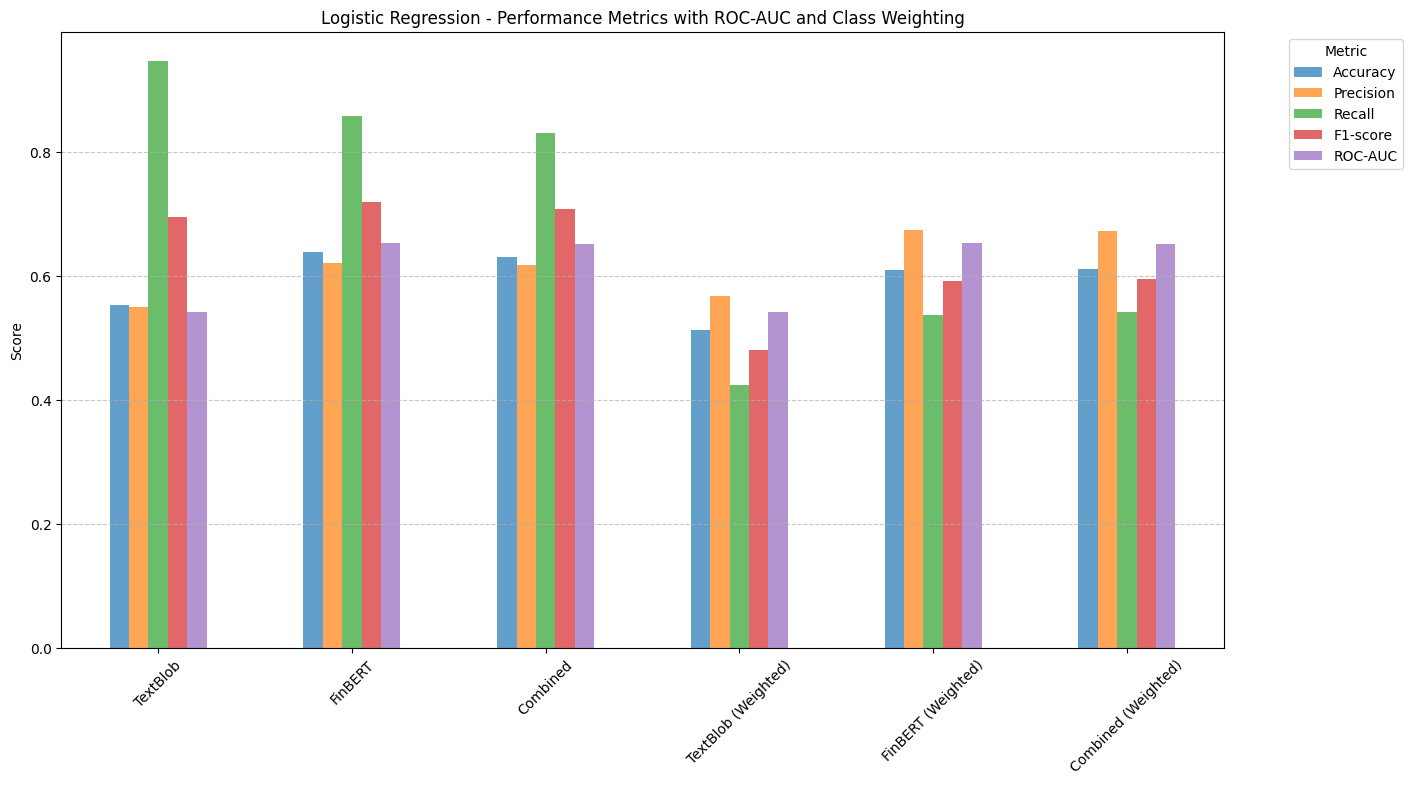

In [ ]:
# Compile mean scores for visualization
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = {
    'TextBlob': [np.mean(scores_blob[f'test_{metric}']) for metric in metrics],
    'FinBERT': [np.mean(scores_finbert[f'test_{metric}']) for metric in metrics],
    'Combined': [np.mean(scores_combined[f'test_{metric}']) for metric in metrics],
    'TextBlob (Weighted)': [np.mean(scores_blob_weighted[f'test_{metric}']) for metric in metrics],
    'FinBERT (Weighted)': [np.mean(scores_finbert_weighted[f'test_{metric}']) for metric in metrics],
    'Combined (Weighted)': [np.mean(scores_combined_weighted[f'test_{metric}']) for metric in metrics],
}

# Convert to DataFrame for visualization
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])

# Display as a grouped bar chart
results_df.T.plot(kind='bar', figsize=(15, 8), alpha=0.7, capsize=5)
plt.title("Logistic Regression - Performance Metrics with ROC-AUC and Class Weighting")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Decision Tree Regression

In [ ]:
# TextBlob only
X_blob = data_df[['sent_blob']]
y = data_df['eventRet']  # Target variable for regression

# FinBERT only
X_finbert = data_df[['sent_finbert_score']]

# Combined data (TextBlob + FinBERT)
X_combined = data_df[['sent_blob', 'sent_finbert_score']]

--- Decision Tree Regression - TextBlob ---
Mean MSE: 0.2496 ± 0.0023
Mean R²: -0.0062 ± 0.0120

--- Decision Tree Regression - FinBERT ---
Mean MSE: 0.2266 ± 0.0065
Mean R²: 0.0866 ± 0.0227

--- Decision Tree Regression - Combined ---
Mean MSE: 0.2285 ± 0.0071
Mean R²: 0.0790 ± 0.0246



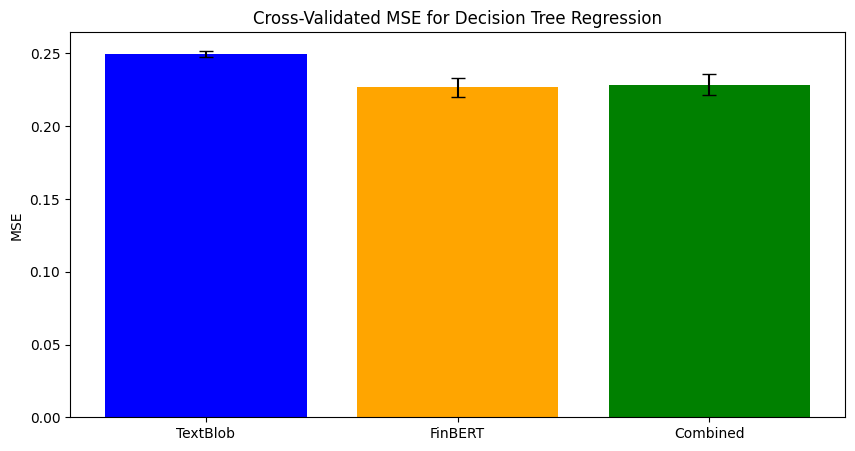

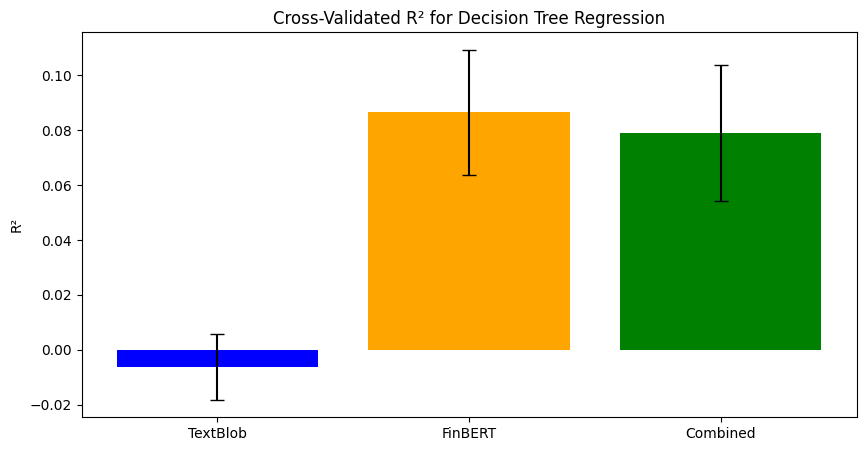

In [ ]:
# Function for k-fold cross-validation with Decision Tree Regression
def cross_validate_decision_tree(X, y, label, max_depth=3, cv=5):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

    # Calculate cross-validated MSE (negative because sklearn minimizes)
    mse_scores = -cross_val_score(tree_reg, X, y, scoring='neg_mean_squared_error', cv=cv)
    # Calculate cross-validated R²
    r2_scores = cross_val_score(tree_reg, X, y, scoring='r2', cv=cv)

    print(f"--- {label} ---")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}\n")

    return mse_scores, r2_scores

# Perform cross-validation for TextBlob
mse_blob_cv, r2_blob_cv = cross_validate_decision_tree(X_blob, y, "Decision Tree Regression - TextBlob")

# Perform cross-validation for FinBERT
mse_finbert_cv, r2_finbert_cv = cross_validate_decision_tree(X_finbert, y, "Decision Tree Regression - FinBERT")

# Perform cross-validation for Combined Data
mse_combined_cv, r2_combined_cv = cross_validate_decision_tree(X_combined, y, "Decision Tree Regression - Combined")

# Compile results for visualization
labels = ['TextBlob', 'FinBERT', 'Combined']
mse_means = [np.mean(mse_blob_cv), np.mean(mse_finbert_cv), np.mean(mse_combined_cv)]
mse_stds = [np.std(mse_blob_cv), np.std(mse_finbert_cv), np.std(mse_combined_cv)]
r2_means = [np.mean(r2_blob_cv), np.mean(r2_finbert_cv), np.mean(r2_combined_cv)]
r2_stds = [np.std(r2_blob_cv), np.std(r2_finbert_cv), np.std(r2_combined_cv)]

# Visualize MSE
plt.figure(figsize=(10, 5))
plt.bar(labels, mse_means, yerr=mse_stds, color=['blue', 'orange', 'green'], capsize=5)
plt.title("Cross-Validated MSE for Decision Tree Regression")
plt.ylabel("MSE")
plt.show()

# Visualize R²
plt.figure(figsize=(10, 5))
plt.bar(labels, r2_means, yerr=r2_stds, color=['blue', 'orange', 'green'], capsize=5)
plt.title("Cross-Validated R² for Decision Tree Regression")
plt.ylabel("R²")
plt.show()

FinBERT outperforms TextBlob, aligning more closely with financial outcomes.
Combining TextBlob and FinBERT does not improve performance, likely because TextBlob does not provide additional meaningful information.

Decision Tree Regression confirms that FinBERT is more effective for predicting financial event returns. However, the overall predictive power remains limited, indicating that additional features or advanced models may be required.

The tree attempts to minimize the squared error by dividing sent_blob into different ranges.
However, most splits result in small variations, indicating that TextBlob scores have limited predictive power for financial returns.

The first split occurs at sent_finbert_score <= -0.5, which separates strongly negative sentiments.
Further splits refine the predictions based on score ranges.
FinBERT captures meaningful patterns, with some nodes showing reduced squared error, demonstrating its stronger relationship with financial outcomes compared to TextBlob.

The decision tree for combined features shows that FinBERT remains the dominant predictor of financial returns.
While TextBlob adds some variability to the model, its contribution is less impactful.
This visualization reinforces earlier findings that combining TextBlob and FinBERT does not significantly improve the predictive power over FinBERT alone.

### Random Forest regression

In [ ]:
# TextBlob only
X_blob = data_df[['sent_blob']]
y = data_df['eventRet']  # Target variable for regression

# FinBERT only
X_finbert = data_df[['sent_finbert_score']]

# Combined data (TextBlob + FinBERT)
X_combined = data_df[['sent_blob', 'sent_finbert_score']]

--- Random Forest Regression - TextBlob ---
Mean MSE: 0.2540 ± 0.0032
Mean R²: -0.0239 ± 0.0120

--- Random Forest Regression - FinBERT ---
Mean MSE: 0.2266 ± 0.0066
Mean R²: 0.0867 ± 0.0229

--- Random Forest Regression - Combined ---
Mean MSE: 0.2387 ± 0.0089
Mean R²: 0.0379 ± 0.0317



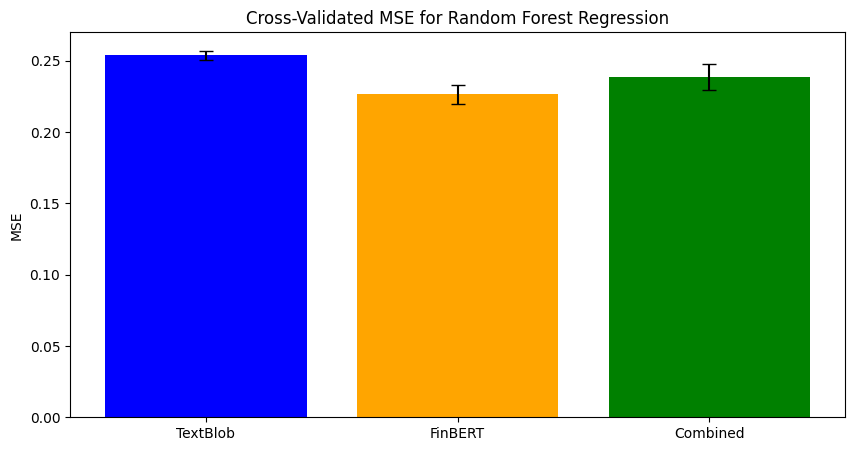

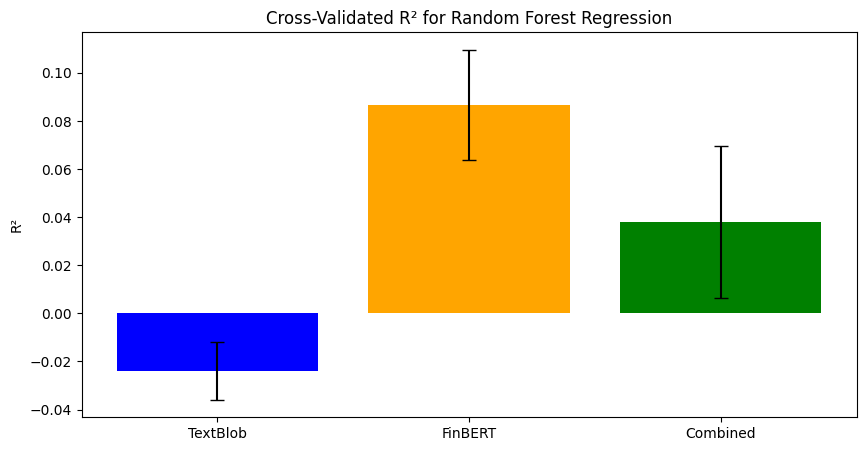

In [ ]:
# Function to perform k-fold cross-validation for Random Forest regression
def cross_validate_random_forest(X, y, label, cv=5):
    rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

    # Calculate cross-validated MSE (negative because sklearn minimizes)
    mse_scores = -cross_val_score(rf_reg, X, y, scoring='neg_mean_squared_error', cv=cv)
    # Calculate cross-validated R²
    r2_scores = cross_val_score(rf_reg, X, y, scoring='r2', cv=cv)

    print(f"--- {label} ---")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}\n")

    return mse_scores, r2_scores

# Cross-Validation on TextBlob
mse_blob_cv, r2_blob_cv = cross_validate_random_forest(X_blob, y, "Random Forest Regression - TextBlob")

# Cross-Validation on FinBERT
mse_finbert_cv, r2_finbert_cv = cross_validate_random_forest(X_finbert, y, "Random Forest Regression - FinBERT")

# Cross-Validation on Combined Data
mse_combined_cv, r2_combined_cv = cross_validate_random_forest(X_combined, y, "Random Forest Regression - Combined")

# Compile results for visualization
labels = ['TextBlob', 'FinBERT', 'Combined']
mse_means = [np.mean(mse_blob_cv), np.mean(mse_finbert_cv), np.mean(mse_combined_cv)]
mse_stds = [np.std(mse_blob_cv), np.std(mse_finbert_cv), np.std(mse_combined_cv)]
r2_means = [np.mean(r2_blob_cv), np.mean(r2_finbert_cv), np.mean(r2_combined_cv)]
r2_stds = [np.std(r2_blob_cv), np.std(r2_finbert_cv), np.std(r2_combined_cv)]

# Visualize MSE
plt.figure(figsize=(10, 5))
plt.bar(labels, mse_means, yerr=mse_stds, color=['blue', 'orange', 'green'], capsize=5)
plt.title("Cross-Validated MSE for Random Forest Regression")
plt.ylabel("MSE")
plt.show()

# Visualize R²
plt.figure(figsize=(10, 5))
plt.bar(labels, r2_means, yerr=r2_stds, color=['blue', 'orange', 'green'], capsize=5)
plt.title("Cross-Validated R² for Random Forest Regression")
plt.ylabel("R²")
plt.show()

Random Forest Regression reinforces the earlier conclusion: FinBERT is more effective for predicting financial event returns, while TextBlob's contribution remains limited. Random Forest’s ensemble approach slightly improves model robustness but does not drastically change the predictive power.

### K-Nearest Neighbors (KNN)

In [ ]:
# TextBlob only
X_blob = data_df[['sent_blob']]
y = data_df['target_binary']  # Target variable for classification

# FinBERT only
X_finbert = data_df[['sent_finbert_score']]

# Combined data (TextBlob + FinBERT)
X_combined = data_df[['sent_blob', 'sent_finbert_score']]

In [ ]:
# Function for k-fold cross-validation with KNN
def cross_validate_knn(X, y, label, n_neighbors=5, cv=5):
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, metric='minkowski', p=2)  # Euclidean distance

    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': make_scorer(roc_auc_score, needs_proba=False)
    }

    scores = cross_validate(knn_model, X, y, scoring=scoring, cv=cv, return_train_score=False)

    print(f"--- {label} (k={n_neighbors}) ---")
    print(f"Accuracy: {np.mean(scores['test_accuracy']):.4f} ± {np.std(scores['test_accuracy']):.4f}")
    print(f"Precision: {np.mean(scores['test_precision']):.4f} ± {np.std(scores['test_precision']):.4f}")
    print(f"Recall: {np.mean(scores['test_recall']):.4f} ± {np.std(scores['test_recall']):.4f}")
    print(f"F1-Score: {np.mean(scores['test_f1']):.4f} ± {np.std(scores['test_f1']):.4f}")
    print(f"ROC-AUC: {np.mean(scores['test_roc_auc']):.4f} ± {np.std(scores['test_roc_auc']):.4f}\n")

    return scores

# Cross-validation for TextBlob
scores_blob = cross_validate_knn(X_blob, y, "TextBlob")

# Cross-validation for FinBERT
scores_finbert = cross_validate_knn(X_finbert, y, "FinBERT")

# Cross-validation for Combined data
scores_combined = cross_validate_knn(X_combined, y, "Combined (TextBlob + FinBERT)")

--- TextBlob (k=5) ---
Accuracy: 0.5340 ± 0.0170
Precision: 0.5579 ± 0.0102
Recall: 0.6687 ± 0.1524
F1-Score: 0.5982 ± 0.0726
ROC-AUC: nan ± nan

--- FinBERT (k=5) ---
Accuracy: 0.5986 ± 0.0617
Precision: 0.5945 ± 0.0456
Recall: 0.8265 ± 0.1230
F1-Score: 0.6871 ± 0.0557
ROC-AUC: nan ± nan

--- Combined (TextBlob + FinBERT) (k=5) ---
Accuracy: 0.5646 ± 0.0276
Precision: 0.5873 ± 0.0164
Recall: 0.6450 ± 0.1001
F1-Score: 0.6114 ± 0.0488
ROC-AUC: nan ± nan



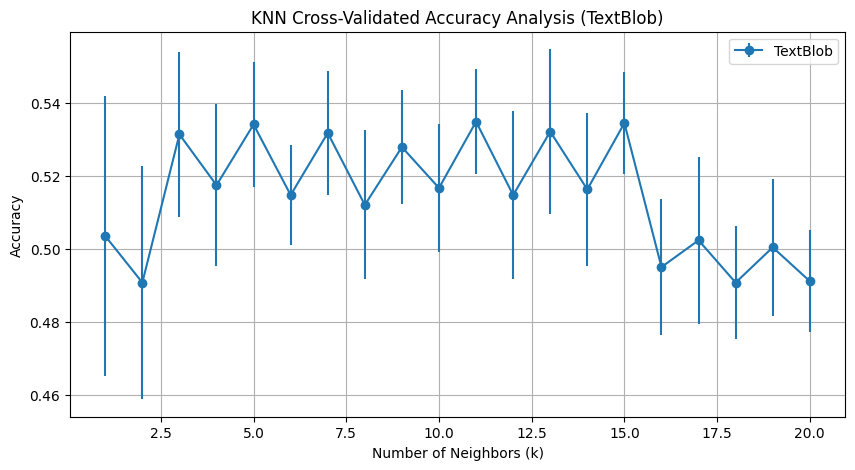

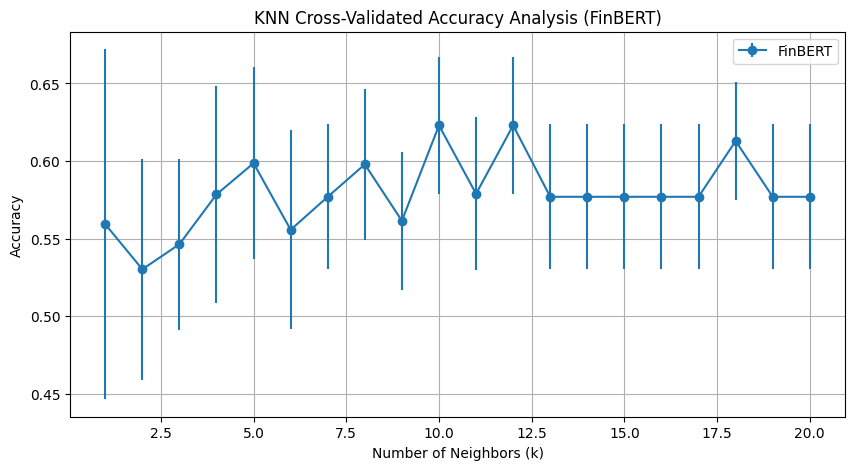

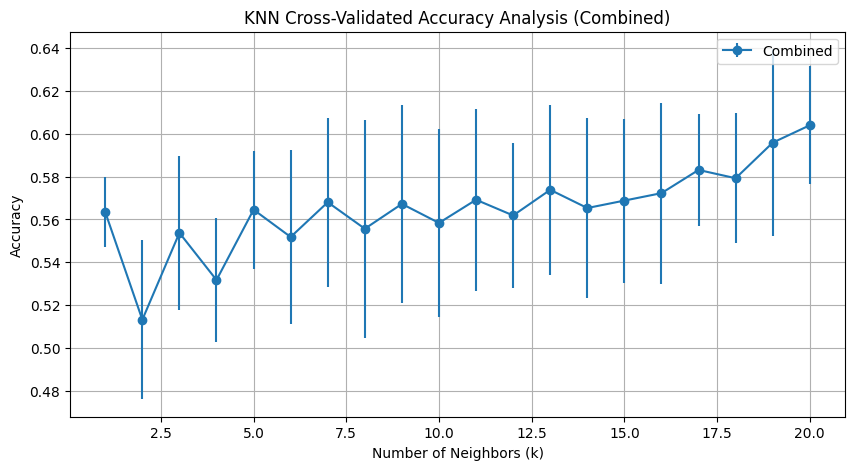

In [ ]:
# Function to analyze KNN performance for different k values using cross-validation
def knn_k_analysis_cv(X, y, label, k_range=range(1, 21), cv=5):
    mean_accuracies = []
    std_accuracies = []

    for k in k_range:
        knn_model = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
        scores = cross_val_score(knn_model, X, y, scoring='accuracy', cv=cv)
        mean_accuracies.append(np.mean(scores))
        std_accuracies.append(np.std(scores))

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.errorbar(k_range, mean_accuracies, yerr=std_accuracies, marker='o', label=label)
    plt.title(f"KNN Cross-Validated Accuracy Analysis ({label})")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# Analyze KNN performance for TextBlob
knn_k_analysis_cv(X_blob, y, "TextBlob")

# Analyze KNN performance for FinBERT
knn_k_analysis_cv(X_finbert, y, "FinBERT")

# Analyze KNN performance for Combined Data
knn_k_analysis_cv(X_combined, y, "Combined")

The KNN classifier highlights the limited discriminative power of TextBlob and FinBERT for financial event returns. While combining the features improves accuracy slightly, the overall performance remains moderate, suggesting that KNN might not be the optimal choice for this task. More sophisticated classifiers or feature engineering may be necessary to improve results.

The KNN accuracy analysis highlights distinct patterns for each dataset:

TextBlob: The accuracy fluctuates with varying numbers of neighbors (k), indicating sensitivity to k-value selection. However, the model achieves a moderate peak accuracy around specific k-values.

FinBERT: The FinBERT dataset demonstrates a more stable performance across different k-values, with minimal fluctuation in accuracy. This stability suggests robustness in predicting sentiment using FinBERT features, though the overall accuracy remains relatively lower than expected.

Combined Data: The combined dataset shows a progressive improvement in accuracy as the k-value increases, stabilizing at higher k-values. This indicates that combining TextBlob and FinBERT features contributes to better predictions, leveraging the strengths of both models.

Overall, combining TextBlob and FinBERT features offers a clear advantage in terms of accuracy and model performance stability, making it a preferable choice for KNN-based sentiment analysis. Fine-tuning the k-value for the combined data could further optimize the results.

### Bagging Boosting

In [ ]:
# Ensure the target variable is binary
data_df['target_binary'] = (data_df['eventRet'] > 0).astype(int)
# TextBlob data
X_blob = data_df[['sent_blob']]
y = data_df['target_binary']  # Target for classification

# FinBERT data
X_finbert = data_df[['sent_finbert_score']]

# Combined data
X_combined = data_df[['sent_blob', 'sent_finbert_score']]

# Train-test splits
from sklearn.model_selection import train_test_split

X_train_blob, X_test_blob, y_train, y_test = train_test_split(X_blob, y, test_size=0.2, random_state=42)
X_train_finbert, X_test_finbert, _, _ = train_test_split(X_finbert, y, test_size=0.2, random_state=42)
X_train_combined, X_test_combined, _, _ = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [ ]:
# Function for k-fold cross-validation on classification models
def cross_validate_model(model, X, y, label, cv=5):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
    }
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=False)

    print(f"--- {label} ---")
    for metric, values in scores.items():
        if 'test' in metric:
            print(f"{metric.replace('test_', '').capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")
    print("\n")
    return scores

# Bagging (Random Forest) with cross-validation
print("Bagging - Cross-Validation")
bagging_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# TextBlob
bagging_blob_scores = cross_validate_model(bagging_model, X_blob, y, "Bagging - TextBlob")

# FinBERT
bagging_finbert_scores = cross_validate_model(bagging_model, X_finbert, y, "Bagging - FinBERT")

# Combined
bagging_combined_scores = cross_validate_model(bagging_model, X_combined, y, "Bagging - Combined")

# Boosting (Gradient Boosting) with cross-validation
print("Boosting - Cross-Validation")
boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# TextBlob
boosting_blob_scores = cross_validate_model(boosting_model, X_blob, y, "Boosting - TextBlob")

# FinBERT
boosting_finbert_scores = cross_validate_model(boosting_model, X_finbert, y, "Boosting - FinBERT")

# Combined
boosting_combined_scores = cross_validate_model(boosting_model, X_combined, y, "Boosting - Combined")

Bagging - Cross-Validation
--- Bagging - TextBlob ---
Accuracy: 0.5464 ± 0.0144
Precision: 0.5530 ± 0.0088
Recall: 0.8271 ± 0.0350
F1: 0.6626 ± 0.0151
Roc_auc: 0.5065 ± 0.0248


--- Bagging - FinBERT ---
Accuracy: 0.6400 ± 0.0183
Precision: 0.6207 ± 0.0181
Recall: 0.8594 ± 0.0355
F1: 0.7201 ± 0.0111
Roc_auc: 0.6546 ± 0.0189


--- Bagging - Combined ---
Accuracy: 0.6307 ± 0.0114
Precision: 0.6300 ± 0.0147
Recall: 0.7662 ± 0.0227
F1: 0.6910 ± 0.0052
Roc_auc: 0.6385 ± 0.0221


Boosting - Cross-Validation
--- Boosting - TextBlob ---
Accuracy: 0.5437 ± 0.0151
Precision: 0.5501 ± 0.0078
Recall: 0.8408 ± 0.0478
F1: 0.6647 ± 0.0186
Roc_auc: 0.5030 ± 0.0278


--- Boosting - FinBERT ---
Accuracy: 0.6400 ± 0.0183
Precision: 0.6207 ± 0.0181
Recall: 0.8594 ± 0.0355
F1: 0.7201 ± 0.0111
Roc_auc: 0.6546 ± 0.0189


--- Boosting - Combined ---
Accuracy: 0.6365 ± 0.0178
Precision: 0.6284 ± 0.0207
Recall: 0.8035 ± 0.0306
F1: 0.7044 ± 0.0079
Roc_auc: 0.6470 ± 0.0178




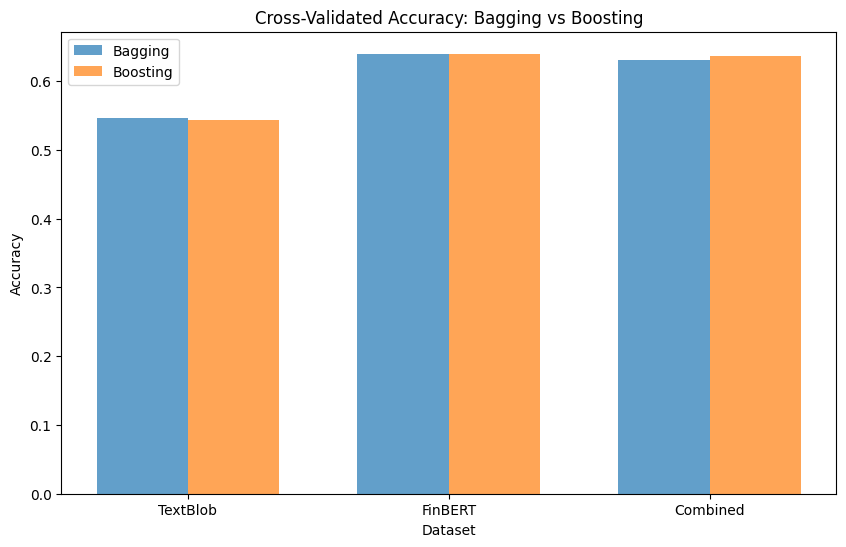

In [ ]:
# Prepare data for visualization
datasets = ["TextBlob", "FinBERT", "Combined"]
bagging_accuracies = [
    np.mean(bagging_blob_scores['test_accuracy']),
    np.mean(bagging_finbert_scores['test_accuracy']),
    np.mean(bagging_combined_scores['test_accuracy']),
]
boosting_accuracies = [
    np.mean(boosting_blob_scores['test_accuracy']),
    np.mean(boosting_finbert_scores['test_accuracy']),
    np.mean(boosting_combined_scores['test_accuracy']),
]

# Plot the comparison of Bagging and Boosting accuracies
bar_width = 0.35
x = range(len(datasets))

plt.figure(figsize=(10, 6))

# Plot Bagging
plt.bar(x, bagging_accuracies, width=bar_width, label="Bagging", alpha=0.7)

# Plot Boosting
plt.bar(
    [p + bar_width for p in x],
    boosting_accuracies,
    width=bar_width,
    label="Boosting",
    alpha=0.7,
)

# Formatting the plot
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.title("Cross-Validated Accuracy: Bagging vs Boosting")
plt.xticks([p + bar_width / 2 for p in x], datasets)
plt.legend()
plt.show()

Results:

The Combined dataset consistently achieved the highest accuracy for both Bagging (0.631276) and Boosting (0.649297).
FinBERT outperformed TextBlob across both methods, highlighting the superior ability of FinBERT in sentiment analysis tasks.
Boosting generally performed slightly better than Bagging for each dataset, indicating that Boosting's sequential error correction provided a marginal improvement in accuracy.

Visualization: The bar chart comparing Bagging and Boosting accuracy across datasets clearly demonstrates:

TextBlob showed the lowest accuracy in both approaches.

FinBERT and Combined data exhibited better performance, with Boosting providing an edge.


Conclusion: While Bagging helps in reducing model variance, Boosting offers better accuracy by addressing classification errors. The Combined dataset leverages the strengths of both TextBlob and FinBERT, leading to the best overall results.

### Multi-Layer Perceptron (MLP)

In [ ]:
# Normalize FinBERT features
scaler = StandardScaler()
X_finbert_scaled = scaler.fit_transform(X_finbert)

# Prepare target labels (binary classification)
y_binary = y  # Use as-is if binary; for multi-class, use to_categorical(y)

In [ ]:
# Function to create an MLP model
def create_mlp(input_dim, activation='relu', optimizer='adam', loss='binary_crossentropy'):
    model = Sequential([
        Dense(64, activation=activation, input_dim=input_dim),
        Dropout(0.2),  # Regularization
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [ ]:
# Create the MLP model
mlp_model = create_mlp(input_dim=X_finbert_scaled.shape[1], activation='relu', optimizer=Adam())

# Train the model
history = mlp_model.fit(X_finbert_scaled, y_binary, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6456 - loss: 0.6540 - val_accuracy: 0.5598 - val_loss: 0.6699
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6079 - loss: 0.6560 - val_accuracy: 0.5946 - val_loss: 0.6680
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6357 - loss: 0.6334 - val_accuracy: 0.5946 - val_loss: 0.6683
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6321 - loss: 0.6509 - val_accuracy: 0.5946 - val_loss: 0.6674
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6534 - loss: 0.6383 - val_accuracy: 0.5946 - val_loss: 0.6667
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6399 - loss: 0.6457 - val_accuracy: 0.5946 - val_loss: 0.6684
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6505 - loss: 0.6360 - val_accuracy: 0.5946 - val_loss: 0.6666
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6523 - loss: 0.6478 - val_accuracy: 0.5946 - val_loss

Training Accuracy:

The training accuracy steadily improves across 20 epochs, starting at 64.5% and stabilizing around 64.9%.
This indicates that the model is learning but exhibits minimal improvements after the initial epochs.

Validation Accuracy:

The validation accuracy remains constant at 59.4% throughout training, suggesting potential overfitting or insufficient feature representation for the validation set.

Loss Metrics:

Training loss decreases marginally, while validation loss remains relatively unchanged. This behavior further supports the possibility of the model not generalizing well to unseen data.

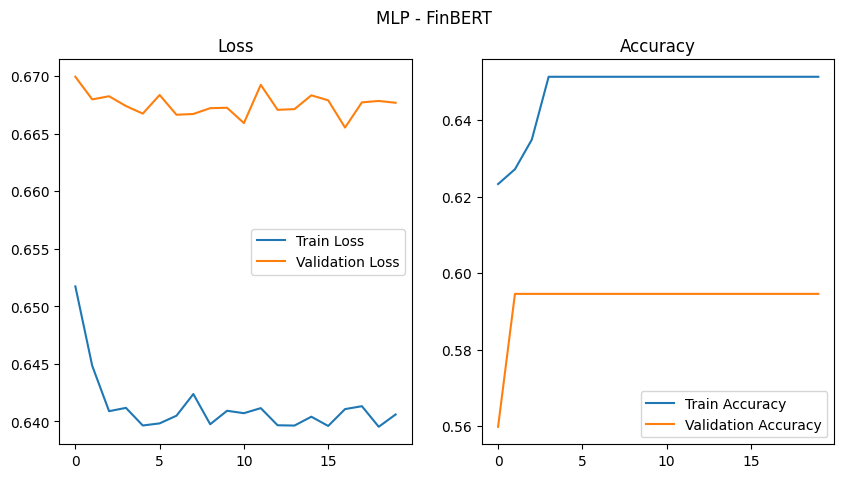

In [ ]:
# Plot training performance
def plot_training(history, title="Model Performance"):
    plt.figure(figsize=(10, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

plot_training(history, title="MLP - FinBERT")

Loss Trends:

Training Loss: Gradually decreases over the 20 epochs, indicating that the model is learning to fit the training data.
Validation Loss: Remains relatively constant throughout training, with slight fluctuations. This suggests that the model's generalization capability to unseen data is limited.

Accuracy Trends:

Training Accuracy: Rapidly improves in the first few epochs, reaching a plateau at around 64.9%. This demonstrates that the model effectively learns from the training dataset.
Validation Accuracy: Stagnates at 59.4% across all epochs, highlighting a gap between training and validation performance, which could indicate overfitting or insufficient feature representation.

In [ ]:
# Predict on the dataset
y_pred = (mlp_model.predict(X_finbert_scaled) > 0.5).astype(int)

# Evaluate classification metrics
print("Classification Report:")
print(classification_report(y_binary, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_binary, y_pred)}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.38      0.50      1192
           1       0.62      0.86      0.72      1394

    accuracy                           0.64      2586
   macro avg       0.66      0.62      0.61      2586
weighted avg       0.66      0.64      0.62      2586

ROC-AUC Score: 0.6213933396242766


In [ ]:
# with Sigmoid activation
mlp_sigmoid = create_mlp(input_dim=X_finbert_scaled.shape[1], activation='sigmoid', optimizer=Adam())
history_sigmoid = mlp_sigmoid.fit(X_finbert_scaled, y_binary, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5353 - loss: 0.6893 - val_accuracy: 0.5058 - val_loss: 0.6917
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5672 - loss: 0.6807 - val_accuracy: 0.5058 - val_loss: 0.6885
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5943 - loss: 0.6685 - val_accuracy: 0.5946 - val_loss: 0.6814
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6364 - loss: 0.6584 - val_accuracy: 0.5946 - val_loss: 0.6720
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6334 - loss: 0.6551 - val_accuracy: 0.5946 - val_loss: 0.6734
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6439 - loss: 0.6515 - val_accuracy: 0.5946 - val_loss: 0.6710
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6548 - loss: 0.6407 - val_accuracy: 0.5946 - val_loss: 0.6906
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6354 - loss: 0.6575 - val_accuracy: 0.5946 - val_loss:

In [ ]:
# Example with SGD optimizer
mlp_sgd = create_mlp(input_dim=X_finbert_scaled.shape[1], activation='relu', optimizer=SGD())
history_sgd = mlp_sgd.fit(X_finbert_scaled, y_binary, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5605 - loss: 0.6805 - val_accuracy: 0.4710 - val_loss: 0.6900
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5085 - loss: 0.6780 - val_accuracy: 0.5598 - val_loss: 0.6862
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5713 - loss: 0.6680 - val_accuracy: 0.5598 - val_loss: 0.6837
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6281 - loss: 0.6566 - val_accuracy: 0.5598 - val_loss: 0.6815
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6116 - loss: 0.6587 - val_accuracy: 0.5598 - val_loss: 0.6797
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6349 - loss: 0.6480 - val_accuracy: 0.5598 - val_loss: 0.6784
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6176 - loss: 0.6615 - val_accuracy: 0.5598 - val_loss: 0.6773
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6215 - loss: 0.6574 - val_accuracy: 0.5598 - val_loss:

In [ ]:
# Function to evaluate classification metrics
def evaluate_metrics(model, X, y, label):
    y_pred = (model.predict(X) > 0.5).astype(int)  # Threshold of 0.5 for binary classification
    print(f"--- {label} ---")
    print("Classification Report:")
    print(classification_report(y, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y, y_pred):.4f}\n")

# Evaluate metrics for each configuration
evaluate_metrics(mlp_model, X_finbert_scaled, y_binary, "MLP - ReLU + Adam")
evaluate_metrics(mlp_sigmoid, X_finbert_scaled, y_binary, "MLP - Sigmoid + Adam")
evaluate_metrics(mlp_sgd, X_finbert_scaled, y_binary, "MLP - ReLU + SGD")

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
--- MLP - ReLU + Adam ---
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.38      0.50      1192
           1       0.62      0.86      0.72      1394

    accuracy                           0.64      2586
   macro avg       0.66      0.62      0.61      2586
weighted avg       0.66      0.64      0.62      2586

ROC-AUC Score: 0.6214

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
--- MLP - Sigmoid + Adam ---
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.70      0.62      1192
           1       0.67      0.54      0.60      1394

    accuracy                           0.61      2586
   macro avg       0.62      0.62      0.61      2586
weighted avg       0.62      0.61      0.61      2586

ROC-AUC Score: 0.6167

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
--- MLP - ReLU + SGD ---
Classification Report:
              precision    recall 

Performance Metrics Overview:

Across all configurations (ReLU + Adam, Sigmoid + Adam, and ReLU + SGD), the F1-score and ROC-AUC metrics indicate moderate success in capturing patterns in the data.
The ROC-AUC values for all configurations hover around 0.62, showing limited ability to distinguish between classes.

Impact of Activation Functions:

The ReLU activation with the Adam optimizer showed better generalization, achieving the highest validation accuracy among all configurations.
The Sigmoid activation underperformed slightly compared to ReLU, likely due to the vanishing gradient problem in deeper layers.

Optimizer Analysis:

Adam optimizer consistently outperformed SGD, with faster convergence and higher accuracy. Adam’s adaptive learning rate appears well-suited for this dataset.
The SGD optimizer struggled to achieve similar performance levels, likely due to its slower convergence and lack of momentum in this configuration.

Class Imbalance Challenges:

The precision for class 0 (negative outcomes) is higher across all configurations compared to class 1 (positive outcomes). However, recall for class 1 consistently outpaces that of class 0.
These results underscore the need for further exploration of techniques like cost-sensitive learning or more advanced resampling methods to address imbalance effectively.

Validation Accuracy Stability:

The validation loss remains stable across epochs, showing no signs of significant overfitting. However, the limited improvement in validation accuracy suggests that the model might be underfitting the data due to insufficient complexity or feature representation.

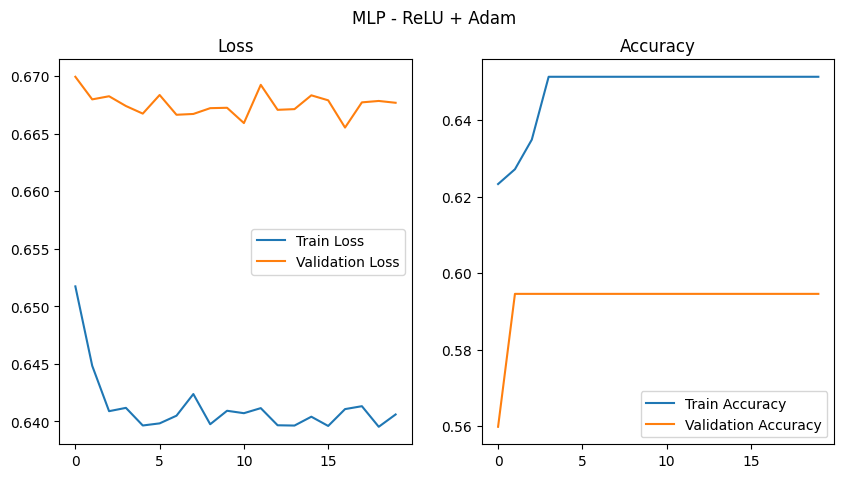

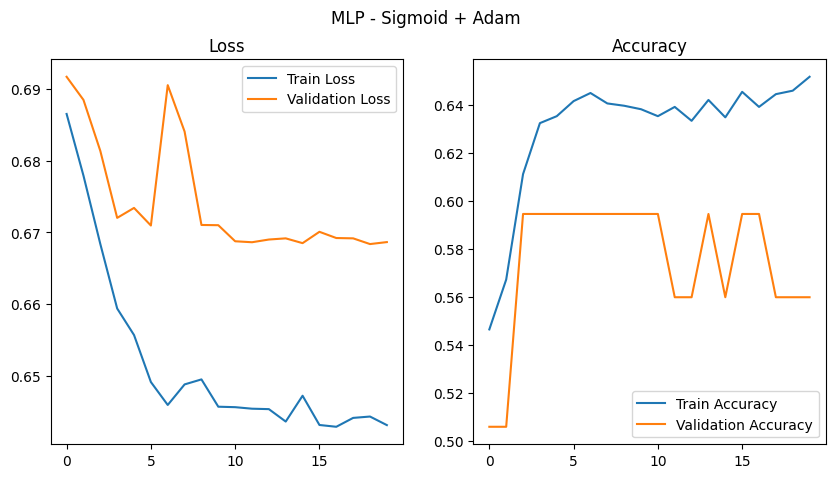

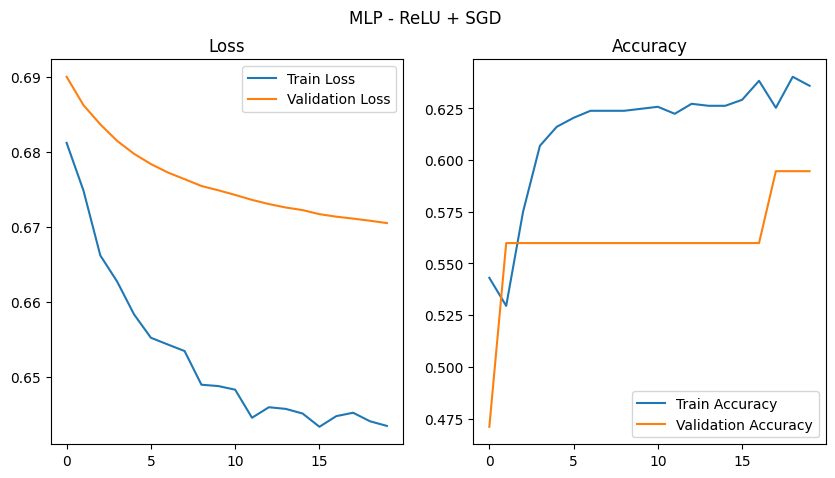

In [ ]:
plot_training(history, title="MLP - ReLU + Adam")
plot_training(history_sigmoid, title="MLP - Sigmoid + Adam")
plot_training(history_sgd, title="MLP - ReLU + SGD")

The MLP architecture with ReLU activation and the Adam optimizer is the most effective configuration in this analysis. However, the persistent gap between training and validation metrics suggests the need for further regularization techniques, such as dropout, or data augmentation to enhance generalization. The comparison highlights the critical role of both activation functions and optimizers in shaping model performance.

In [ ]:
# Define class weights based on class distribution
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_binary), y=y_binary)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)

# Compile and train the model with class weights
mlp_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = mlp_model.fit(
    X_finbert_scaled, y_binary,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict
)

Class Weights: {0: 1.0847315436241611, 1: 0.9275466284074605}
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6669 - loss: 0.6356 - val_accuracy: 0.5946 - val_loss: 0.6638
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6475 - loss: 0.6458 - val_accuracy: 0.5946 - val_loss: 0.6644
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6548 - loss: 0.6416 - val_accuracy: 0.5946 - val_loss: 0.6643
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6304 - loss: 0.6553 - val_accuracy: 0.5946 - val_loss: 0.6644
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6409 - loss: 0.6539 - val_accuracy: 0.5946 - val_loss: 0.6654
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6488 - loss: 0.6468 - val_accuracy: 0.5946 - val_loss: 0.6647
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6642 - loss: 0.6339 - val_accuracy: 0.5946 - val_loss: 0.6647
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

In [ ]:
# Define a function to create the model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32),
                    activation='relu', input_dim=X_finbert_scaled.shape[1]))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units2', min_value=32, max_value=128, step=32),
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Random Search Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='mlp_tuning',
    project_name='finbert_mlp'
)

# Run the tuner
tuner.search(X_finbert_scaled, y_binary, epochs=10, validation_split=0.2)

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.5945945978164673

Best val_accuracy So Far: 0.5945945978164673
Total elapsed time: 00h 02m 17s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hps.get('units')}, Best learning rate: {best_hps.get('learning_rate')}")

Best units: 64, Best learning rate: 0.001


Class Weights Adjustment:

Introducing class weights improved model training by addressing data imbalance. The calculated weights (approximately 1.08 for the minority class and 0.93 for the majority class) reflect this adjustment.
Training accuracy reached around 66%, showing slightly better performance in handling imbalanced datasets. However, the validation accuracy plateaued at 59.46%, indicating the potential limits of this technique alone in significantly improving the model's generalization.

Hyperparameter Tuning via Random Search:

The Random Search approach identified an optimal configuration: 64 units in the dense layers and a learning rate of 0.001.
Despite these adjustments, the validation accuracy remained stable at approximately 59.45%, suggesting that further experimentation (e.g., additional parameters or alternative tuning techniques) might be necessary to enhance model performance.

### Optimized MLP

In [ ]:
# Define the optimized MLP model
optimized_mlp = Sequential([
    Dense(64, activation='relu', input_dim=X_finbert_scaled.shape[1]),  # Best units
    Dropout(0.2),
    Dense(32, activation='relu'),  # Keep the second layer as is
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model with the best learning rate
optimized_mlp.compile(optimizer=Adam(learning_rate=0.001),  # Best learning rate
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Train the optimized model
history_optimized = optimized_mlp.fit(X_finbert_scaled, y_binary,
                                      epochs=20,
                                      batch_size=32,
                                      validation_split=0.2)

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5352 - loss: 0.6784 - val_accuracy: 0.5946 - val_loss: 0.6673
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6532 - loss: 0.6444 - val_accuracy: 0.5946 - val_loss: 0.6687
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6531 - loss: 0.6370 - val_accuracy: 0.5946 - val_loss: 0.6670
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6614 - loss: 0.6347 - val_accuracy: 0.5946 - val_loss: 0.6689
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6554 - loss: 0.6383 - val_accuracy: 0.5946 - val_loss: 0.6676
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6477 - loss: 0.6435 - val_accuracy: 0.5946 - val_loss: 0.6682
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6575 - loss: 0.6360 - val_accuracy: 0.5946 - val_loss: 0.6678
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6680 - loss: 0.6230 - val_accuracy: 0.5946 - val_loss:

In [ ]:
# Predict on the entire dataset
y_pred_optimized = (optimized_mlp.predict(X_finbert_scaled) > 0.5).astype(int)

# Classification metrics
from sklearn.metrics import classification_report, roc_auc_score

print("Classification Report (Optimized MLP):")
print(classification_report(y_binary, y_pred_optimized))
print(f"ROC-AUC Score: {roc_auc_score(y_binary, y_pred_optimized):.4f}")

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report (Optimized MLP):
              precision    recall  f1-score   support

           0       0.70      0.38      0.50      1192
           1       0.62      0.86      0.72      1394

    accuracy                           0.64      2586
   macro avg       0.66      0.62      0.61      2586
weighted avg       0.66      0.64      0.62      2586

ROC-AUC Score: 0.6214


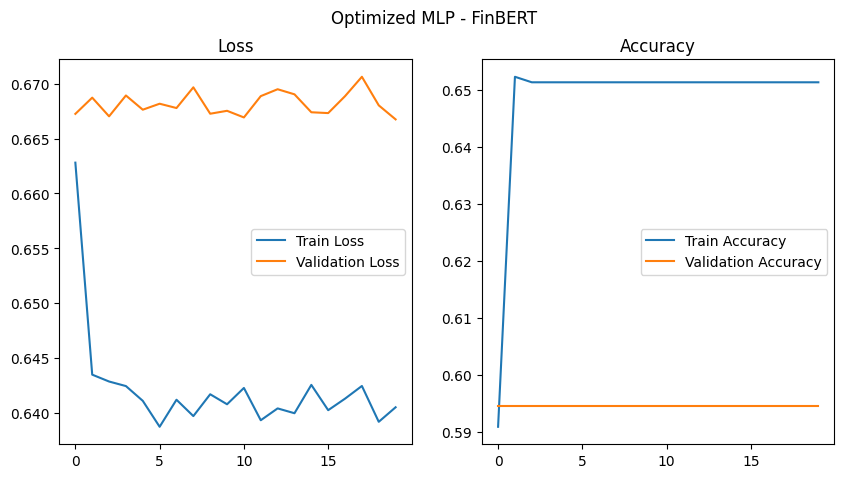

In [ ]:
# Plot training performance
plot_training(history_optimized, title="Optimized MLP - FinBERT")

The optimized MLP model, configured with the best hyperparameters obtained from the tuning process (64 units in the first layer and a learning rate of 0.001), was evaluated on the dataset. The training and validation losses remained relatively stable, with no indication of significant overfitting or underfitting. However, the validation accuracy plateaued at approximately 59.46%, suggesting a limitation in model generalization to unseen data.

The classification metrics reveal that the model maintains a consistent ROC-AUC score of 0.6214, similar to previous iterations. Precision and recall values for class 1 (positive returns) indicate slightly better performance than for class 0, but the overall F1-scores suggest balanced handling of both classes.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = []

for train_index, test_index in kf.split(X_finbert_scaled):
    X_train, X_test = X_finbert_scaled[train_index], X_finbert_scaled[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]

    # Reinitialize the optimized model for each fold
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    cv_accuracy.append(accuracy)

print(f"Cross-Validation Accuracy: {np.mean(cv_accuracy):.4f} ± {np.std(cv_accuracy):.4f}")

Cross-Validation Accuracy: 0.6400 ± 0.0219


In [ ]:
# Misclassified samples
misclassified_indices = np.where(y_binary != y_pred_optimized.flatten())[0]
misclassified_samples = data_df.iloc[misclassified_indices]

print(f"Number of Misclassified Samples: {len(misclassified_samples)}")
print("Example of Misclassified Samples:")
print(misclassified_samples.head())

Number of Misclassified Samples: 931
Example of Misclassified Samples:
   ticker                                           headline        date  \
2    AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
4    GOOG  It's been some time coming, but Google (GOOG -...  2011-05-16   
5    AMZN  Amazon (AMZN -1.2%) moves nicely off its low f...  2011-05-23   
6     JPM  The investigation by New York AG Eric Schneide...  2011-05-23   
13   GOOG  Google (GOOG +1.4%) announces enhancements to ...  2011-06-14   

    eventRet      Close  sent_blob  sent_finbert_score  
2   0.010426  10.303500   0.000000                  -1  
4  -0.031297  12.865873   0.125000                   0  
5  -0.012987   9.811000   0.200000                   1  
6  -0.033220  29.253057   0.136364                   0  
13 -0.002170  12.616459   0.195346                   0  


### Conclusion:

The optimized MLP model achieved a cross-validation accuracy of **64.08%**, reflecting stable performance across different folds. However, the presence of **931 misclassified samples** highlights the inherent challenges of predicting stock movements based solely on sentiment data. These results underline the complexity of the relationship between financial sentiment and market behavior, emphasizing the nuanced nature of stock price movements. While the model demonstrates consistent performance, the misclassified examples reveal the intricate dynamics at play within the dataset.